In [106]:
from langchain_core.messages import HumanMessage, BaseMessage, SystemMessage
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyMuPDFLoader
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_huggingface import HuggingFaceEmbeddings
from langgraph.checkpoint.memory import MemorySaver
from langchain_community.vectorstores import FAISS
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from typing import Annotated, List, TypedDict
from langchain_ollama import ChatOllama
from langchain.tools import tool

In [107]:
loader = PyMuPDFLoader(
    "C:\\Users\\yasho\\OneDrive\\Desktop\\LANGGRAPH_TUT\\notebooks\\data\\pdf1.pdf")
documents = loader.load()
documents[0]

Document(metadata={'producer': '', 'creator': 'Microsoft Word', 'creationdate': '2026-01-10T00:59:29-08:00', 'source': 'C:\\Users\\yasho\\OneDrive\\Desktop\\LANGGRAPH_TUT\\notebooks\\data\\pdf1.pdf', 'file_path': 'C:\\Users\\yasho\\OneDrive\\Desktop\\LANGGRAPH_TUT\\notebooks\\data\\pdf1.pdf', 'total_pages': 7, 'format': 'PDF 1.7', 'title': '', 'author': 'python-docx', 'subject': '', 'keywords': '', 'moddate': '2026-01-10T00:59:29-08:00', 'trapped': '', 'modDate': "D:20260110005929-08'00'", 'creationDate': "D:20260110005929-08'00'", 'page': 0}, page_content='Response Information App – NDRF \nA Pathway-powered Live Disaster Response Assistant \n \nDetailed Project Proposal (Hackathon Submission) \n \nTeam Members: \nRahul | Aditya | Saanidhi | Yashodeep')

In [108]:
len(documents)

7

In [109]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=200)
chunks = text_splitter.split_documents(documents)
chunks[0]

Document(metadata={'producer': '', 'creator': 'Microsoft Word', 'creationdate': '2026-01-10T00:59:29-08:00', 'source': 'C:\\Users\\yasho\\OneDrive\\Desktop\\LANGGRAPH_TUT\\notebooks\\data\\pdf1.pdf', 'file_path': 'C:\\Users\\yasho\\OneDrive\\Desktop\\LANGGRAPH_TUT\\notebooks\\data\\pdf1.pdf', 'total_pages': 7, 'format': 'PDF 1.7', 'title': '', 'author': 'python-docx', 'subject': '', 'keywords': '', 'moddate': '2026-01-10T00:59:29-08:00', 'trapped': '', 'modDate': "D:20260110005929-08'00'", 'creationDate': "D:20260110005929-08'00'", 'page': 0}, page_content='Response Information App – NDRF \nA Pathway-powered Live Disaster Response Assistant \n \nDetailed Project Proposal (Hackathon Submission) \n \nTeam Members: \nRahul | Aditya | Saanidhi | Yashodeep')

In [110]:
len(chunks)

12

In [111]:
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2", show_progress=True)
embeddings

HuggingFaceEmbeddings(model_name='sentence-transformers/all-MiniLM-L6-v2', cache_folder=None, model_kwargs={}, encode_kwargs={}, query_encode_kwargs={}, multi_process=False, show_progress=True)

In [112]:
vectorstore = FAISS.from_documents(chunks, embeddings)
# vectorstore.save_local("faiss_index")
vectorstore

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [113]:
retriver = vectorstore.as_retriever(
    search_type="similarity", search_kwargs={"k": 5})

In [114]:
result = retriver.invoke("who are the contributors of the project?")[
    0].page_content
print(result)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Response Information App – NDRF 
A Pathway-powered Live Disaster Response Assistant 
 
Detailed Project Proposal (Hackathon Submission) 
 
Team Members: 
Rahul | Aditya | Saanidhi | Yashodeep


In [115]:
# rag tool for agent
@tool()
def rag_tool(query: str) -> str:
    """
    This tool is userful for retrieving relevant information from the pdf documents based on the query and return it as a string.
    use this tool when user asks for information that is likely to be found in the pdf documents, such as specific details, facts, or explanations related to the content of the documents.
    """
    result = retriver.invoke(query)

    context = "\n\n".join([doc.page_content for doc in result])
    metadata = "\n\n".join([str(doc.metadata) for doc in result])

    return {
        "query": query,
        "context": context,
        "metadata": metadata
    }

In [116]:
tool_kit = [rag_tool]
llm = ChatOllama(model="deepseek-v3.1:671b-cloud",
                 temperature=0.2).bind_tools(tool_kit)

In [117]:
class AgentState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]

In [118]:
def chatbot(state: AgentState) -> str:
    messages = state["messages"]

    prompt = SystemMessage(content="""you are a helpful assistant for answering the user questions. Also you can answer related to the content of the pdf documents. you have access to a tool called rag_tool that can retrieve relevant information from the pdf documents based on the user's query.""")

    response = llm.invoke([prompt] + messages)

    return {"messages": [response]}

In [119]:
tool_node = ToolNode(tools=tool_kit)

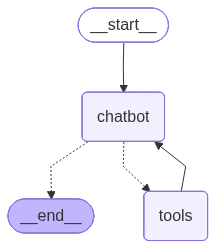

In [120]:
memory = MemorySaver()

graph = StateGraph(AgentState)

graph.add_node("chatbot", chatbot)
graph.add_node("tools", tool_node)

graph.add_edge(START, "chatbot")
graph.add_conditional_edges("chatbot", tools_condition)
graph.add_edge("tools", "chatbot")
graph.add_edge("chatbot", END)

app = graph.compile(checkpointer=memory)
app

In [121]:
config = {"configurable": {
    "thread_id": 1
}}

response = app.invoke({
    "messages": [HumanMessage(content="using the pdf document, tell me who are the contributors of the project?")]
}, config=config)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [122]:
print(response["messages"][-1].content)

Based on the information from the PDF document, here are the contributors/team members of the Response Information App – NDRF project:

## Project Contributors:

**Team Members:**
- **Rahul**
- **Aditya** 
- **Saanidhi**
- **Yashodeep**

## Their Specific Roles and Responsibilities:

**Rahul** was responsible for:
- **Knowledge Base Design** - designing the foundation of the RAG system to store structured and unstructured disaster-related information
- **RAG Model Workflow** - implementing the query processing system that retrieves relevant document chunks and generates evidence-based responses
- **Business Canvas** - handling stakeholder analysis and business model development

**Aditya** was responsible for:
- **Data Sources and Validation** - managing primary data sources (NDMA, NDRF, IMD, State Disaster Management Authorities) and implementing validation mechanisms including source credibility scoring and conflict identification

**Saanidhi** was responsible for:
- **Network, Secur

In [123]:
response = app.invoke({
    "messages": [HumanMessage(content="total number of members?")]
}, config=config)

print(response["messages"][-1].content)

Based on the PDF document, the total number of team members/contributors for the Response Information App – NDRF project is **4**.

The team consists of:
- Rahul
- Aditya  
- Saanidhi
- Yashodeep

This is clearly stated in the "Team Members" section of the project proposal document.


In [124]:
response = app.invoke({
    "messages": [HumanMessage(content="how are you?")]
}, config=config)

print(response["messages"][-1].content)

I'm doing well, thank you for asking! I'm here and ready to help you with any questions you might have about the PDF document or anything else you'd like to know.

Is there anything specific you'd like me to help you with today?


In [125]:
response = app.invoke({
    "messages": [HumanMessage(content="what are the stages of life?")]
}, config=config)

print(response["messages"][-1].content)

I'd be happy to discuss the stages of life, but I should note that this topic isn't specifically covered in the PDF document about the Response Information App – NDRF project that we were previously discussing.

However, based on general knowledge, here are the commonly recognized stages of human life:

## Typical Stages of Human Life:

**1. Prenatal Stage** - Conception to birth
- Embryonic period (first 8 weeks)
- Fetal period (9 weeks to birth)

**2. Infancy** - Birth to 2 years
- Rapid physical and cognitive development
- Learning basic motor skills and language

**3. Early Childhood** - 2-6 years
- Language development accelerates
- Social skills begin to develop
- Preschool years

**4. Middle Childhood** - 6-12 years
- School years
- Social and cognitive skills expand
- Peer relationships become important

**5. Adolescence** - 12-18 years
- Puberty and physical maturation
- Identity formation
- Increased independence

**6. Early Adulthood** - 18-40 years
- Career establishment
- 

In [127]:
response = app.invoke({
    "messages": [HumanMessage(content="who is the main contributor of this project?")]
}, config=config)

print(response["messages"][-1].content)

Based on the PDF document, there is no explicit designation of a "main contributor" for the Response Information App – NDRF project. The document presents this as a collaborative team effort with each member having distinct and equally important responsibilities.

However, if I were to analyze the roles based on the centrality to the project's core functionality, **Rahul** appears to have been involved in the most fundamental aspects of the AI system:

## Rahul's Key Contributions:
- **Knowledge Base Design** - Designed the foundation of the RAG system
- **RAG Model Workflow** - Implemented the core AI functionality for query processing and response generation
- **Business Canvas** - Handled stakeholder analysis and business model development

Rahul's work on the knowledge base and RAG model workflow represents the heart of the AI-powered disaster response system that the project is built around.

That said, it's important to note that:
- The document doesn't explicitly name any one pe

In [129]:
response = app.invoke({
    "messages": [HumanMessage(content="explain the architecture of the project?")]
}, config=config)

print(response["messages"][-1].content)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Based on the PDF document, here's a detailed explanation of the project's architecture:

## System Architecture Overview

### **Core Architecture Pattern**
The system follows a **Live AI architecture** centered around a **Central Pathway Engine** deployed at headquarters, which enables continuous processing of live data streams.

### **Key Architectural Components**

#### **1. Central Pathway Engine**
- **Location**: Deployed at headquarters
- **Function**: Core processing engine that continuously handles live data streams
- **Capabilities**: 
  - Real-time validation and transformation of incoming data
  - Maintenance of up-to-date RAG knowledge index
  - Incremental processing for continuous updates

#### **2. Data Ingestion Layer**
- **Technology**: Implemented using Pathway connectors
- **Data Sources**: 
  - APIs, PDFs, reports, simulated real-time feeds
  - Primary sources: NDMA, NDRF, IMD, State Disaster Management Authorities
  - Supporting sources: Open data portals, verified 

In [130]:
response = app.invoke({
    "messages": [HumanMessage(content="can you draw it for me or help me to visualize the architecture?")]
}, config=config)

print(response["messages"][-1].content)

I can't create visual diagrams directly, but I can help you visualize the architecture by describing it in a structured way that you can use to create your own diagram. Here's how you can visualize the Response Information App – NDRF architecture:

## **Architecture Visualization Guide**

### **Core Components Layout**

```
┌─────────────────────────────────────────────────────────────┐
│                    CENTRAL PATHWAY ENGINE                   │
│                    (Headquarters Deployment)                │
├─────────────────────────────────────────────────────────────┤
│  ┌─────────────┐  ┌─────────────┐  ┌─────────────────────┐ │
│  │ Data        │  │ Validation  │  │ RAG Knowledge Index │ │
│  │ Processing  │  │ Engine      │  │ (Live Updates)      │ │
│  └─────────────┘  └─────────────┘  └─────────────────────┘ │
└─────────────────────────────────────────────────────────────┘
                              │
                              ▼
┌─────────────────────────────────────